In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    model.compile(loss="mse", optimizer="rmsprop")
    
    return model

In [3]:
def create_train_sets_from_input_data(input_list, n_elem_to_ignore, seq_len):
    
    '''
    gets input data and outputs train data sets
    input:
        input_list = time series data as a list
        n_elem_to_ignore = number of elements to be not used for predictions
        seq_len = sequence length to be used for NN training
    output:
        x_train
        y_train
        first_row_for_forecast
        last_n_actuals
    '''
    full_data = input_list
    
    if full_data[len(full_data) - 1] == '':
        full_data = full_data[ : -1]
       
    #now, data would have all the data elements
    #we should not use the last 13 data points
    #so we create a new list that has data only till t - 13
    
    data = full_data[: -(n_elem_to_ignore+2)]
    last_n_actuals = full_data[-n_elem_to_ignore:]
    
    sequence_length = seq_len + 1
    result = []
    
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)

    train = result[:result.shape[0], :]
    
    x_train = train[:-1, :-1]
    y_train = train[:-1, -1]
    
    first_row_for_forecast = train[-1, :-1]
   
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    first_row_for_forecast = np.reshape(first_row_for_forecast, (1,first_row_for_forecast.shape[0],1))
    
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, first_row_for_forecast, last_n_actuals]

In [4]:
def fn_create_model(x_train,y_train,seq_len):

    '''
    function takes in training sets and fits to a NN model
    
    input:
        x_train = x train data set.. comes from prev function
        y_train = y train data set.. comes from prev function
        seq_len = same as the seq len used in prev function
    
    output:
        NN model fit with the input data
        '''
    
    #build model
    model = build_model([1, seq_len, 100, 1])

    #fit model for this data
    model.fit(
        x_train,
        y_train,
        batch_size=512,
        nb_epoch=1,
        validation_split=0.05)
    
    return model

In [5]:
def fn_do_predictions_using_first_row_for_forecast(model, first_row_for_forecast, k_prediction_len):
    
    '''
    input:
        model = NN fit model from prev function
        first_row_for_forecast = from 1st function
        k_prediction_len = user input; length of the predictions
        
    output:
        predicted values for the length in input
    
    '''
    
    inp_for_forecast = first_row_for_forecast
    predictions_list = []
    
    for i in range(k_prediction_len):
    
        predicted = model.predict(inp_for_forecast)
        predicted = np.reshape(predicted, (predicted.size,))
        predictions_list.append(predicted[0])
        
        temp_list = inp_for_forecast[0].tolist()

        temp_list = temp_list[1:]
        temp_list.append([predicted[0]])

        inp_for_forecast = np.array(temp_list)
        inp_for_forecast = np.reshape(a=inp_for_forecast, newshape=(1, inp_for_forecast.shape[0],1))
    
    
    return [predictions_list]

In [17]:
def fn_get_inputs_print_results(data_list,n_elements_to_ignore,k_predictions,seq_len):
    '''
    function takes in the input; calls the other 3 functions to do predictions
    input:
        data_list = list of time series elements
        n_elements_to_ignore = #elements to ignore
        k_predictions = # future predictions to make
        seq_len = length of NN seq
        
    output:
        predictions as a list
    '''
    
    #call the fn to get data
    x_train, y_train, first_row_for_forecast, last_n_actuals = create_train_sets_from_input_data(input_list=data_list,
                                      n_elem_to_ignore=n_elements_to_ignore,
                                      seq_len=seq_len)
    
    #build model with the above data
    model = fn_create_model(x_train,y_train,seq_len)
    
    #do predictions
    
    predictions = fn_do_predictions_using_first_row_for_forecast(model=model,
                                                   first_row_for_forecast = first_row_for_forecast,
                                                   k_prediction_len = k_predictions)
    
    return predictions

In [7]:
sine_wave_csv = pd.read_csv('LSTM_sine_wave_data.csv',names=['val'])

In [8]:
sine_wave_vals = list(sine_wave_csv.val)

In [18]:
op_pred = fn_get_inputs_print_results(data_list=sine_wave_vals,
                                      k_predictions=200,n_elements_to_ignore=0,seq_len=50)

Train on 4699 samples, validate on 248 samples
Epoch 1/1
4699/4699 [==============================] - 58s - loss: 0.1332 - val_loss: 0.0019


In [14]:
op_pred

[[-0.002422163,
  0.051157605,
  0.10595496,
  0.16186994,
  0.21872564,
  0.27624887,
  0.33406478,
  0.39169699,
  0.44856867,
  0.5040158,
  0.55731261,
  0.60772115,
  0.65455633,
  0.69725639,
  0.73544031,
  0.76893806,
  0.79778564,
  0.82218474,
  0.84244215,
  0.85889786,
  0.87186503,
  0.88158751,
  0.88822162,
  0.89184111,
  0.89245367,
  0.8900162,
  0.88445103,
  0.87565297,
  0.86348623,
  0.84777939,
  0.82831079,
  0.80479336,
  0.77685803,
  0.74404591,
  0.70581824,
  0.66160381,
  0.61090493,
  0.55348003,
  0.48957735,
  0.42013177,
  0.346775,
  0.27155089,
  0.19642819,
  0.12286223,
  0.051622652,
  -0.017116722,
  -0.083561011,
  -0.14807776,
  -0.21104303,
  -0.27276087,
  -0.3334375,
  -0.39312461,
  -0.45209062,
  -0.51021832,
  -0.56735069,
  -0.62328225,
  -0.67775083,
  -0.73043197,
  -0.78093559,
  -0.82880813,
  -0.87354398,
  -0.91461319,
  -0.95149624,
  -0.98372459,
  -1.0109195,
  -1.0328175,
  -1.0492797,
  -1.0602905,
  -1.0659426,
  -1.0664105,


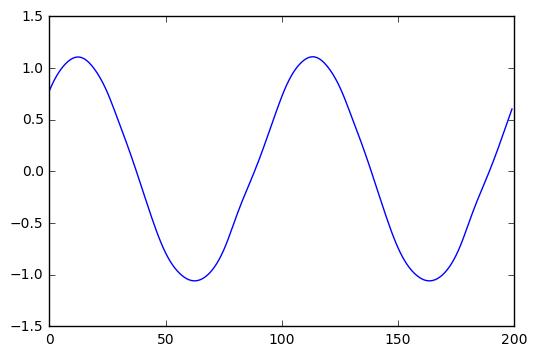

In [19]:
plt.plot(op_pred[0])
plt.show()